In [2]:
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
sys.path.append('../')
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Bella")

In [3]:
# set up the python objects for the geecs devices to be used in optimization
hexapod = GeecsDevice('HEX-PL1-2')
# camera = GeecsDevice('CAM-HPD-CCD')
# get value of hex
yposition = hexapod.get('ypos')
ylow = yposition - 0.1
yhigh = yposition + 0.1
zposition = hexapod.get('zpos')
zlow = zposition - 0.1
zhigh = zposition + 0.1
print(zhigh,'Check zhigh makes sense')

-0.648 Check zhigh makes sense


In [4]:


# define a dict containing the specific variables and bounds to be used in optimization
objs={'var1':{"GEECS_Object":hexapod,'variable':"ypos","bounds":[ylow,yhigh]},
    'var2':{"GEECS_Object":hexapod,'variable':"zpos","bounds":[zlow,zhigh]}}

#define whether or not to use normalized values and ranges for optimization controls. 
#Normalization seems like a good idea
normalize=True

#for opt method, choose nelder or bayes for now
opt_method='bayes'

In [5]:
# stage.set('exposure',0.0015)

In [6]:
# value=dev1.get('exposure')
# print(value,'sokdfhksd')

In [7]:
#define the xopt configuration
YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name:
evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
        {}
    objectives: {f: "MAXIMIZE"}

"""

yaml_output = yaml.safe_load(YAML)

if opt_method == 'bayes':
    yaml_output['generator']['name'] = 'upper_confidence_bound'
    yaml_output['generator']['n_initial'] = 2
    yaml_output['generator']['acq'] = {'beta':0.1}
    yaml_output['xopt']['dump_file'] = 'bayes.yaml'
elif opt_method == 'nelder':
    yaml_output['generator']['name'] = 'neldermead'
    yaml_output['generator']['adaptive'] = True
    yaml_output['generator']['xatol'] = 0.01
    yaml_output['generator']['fatol'] = 0.005
    yaml_output['generator']['initial_point'] = { "var1": 0.006}
    yaml_output['xopt']['dump_file'] = 'nelder.yaml'

#define some functions to normalize/unnormalize real variables to [-1,1]
def unnormalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=(val/2+0.5)*range+offset
    return new_val

def normalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=((val - offset)/range - 0.5)*2
    return new_val
    

for tag in objs.keys():
    yaml_output['vocs']['variables'][tag]=objs[tag]['bounds']
    
if normalize:
    for tag in objs.keys():
        yaml_output['vocs']['variables'][tag]=[-1.0,1.0]
    keys = yaml_output['vocs']['variables'].keys()
    

if yaml_output['generator']['name']=='neldermead':
    if normalize:
        initial_point = yaml_output['generator']['initial_point']

        normalized_initial_point = {}
        for key in keys:
            normalized_initial_point[key] = normalize_var(key, initial_point[key])

        yaml_output['generator']['initial_point'] = normalized_initial_point

print(yaml_output)

{'xopt': {'dump_file': 'bayes.yaml'}, 'generator': {'name': 'upper_confidence_bound', 'n_initial': 2, 'acq': {'beta': 0.1}}, 'evaluator': {'function': '__main__.geecs_measurement'}, 'vocs': {'variables': {'var1': [-1.0, 1.0], 'var2': [-1.0, 1.0]}, 'objectives': {'f': 'MAXIMIZE'}}}


In [8]:
# dev1.set('exposure',0.15)

In [9]:
# #simulate transmission of blue diode through PMQ triplet
# import numpy as np

# optPosition = np.array([18.45, 0.6])
# numParts = 200000

# startDist = np.transpose([
#     np.random.normal(optPosition[0], 0.4, numParts),
#     np.random.normal(optPosition[1], 0.4, numParts)
# ])

# def calcTransmission(input_dict):
#     center1 = [input_dict['HexY'], input_dict['HexZ']]
#     separation = 15

#     center2 = [input_dict['HexY'], input_dict['HexZ']]
#     rotw = np.pi / 180 * (input_dict['HexW'] + 0.15) * 4
#     rotv = np.pi / 180 * (input_dict['HexV'] + 0.25) * 4

#     yOffset = separation * np.tan(rotw)
#     zOffset = separation * np.tan(rotv)

#     center2[0] = center2[0] + yOffset
#     center2[1] = center2[1] + zOffset

#     dist = startDist[
#         (np.sqrt((startDist[:, 0] - center1[0])**2 + (startDist[:, 1] - center1[1])**2) < 0.2) &
#         (np.sqrt((startDist[:, 0] - center2[0])**2 + (startDist[:, 1] - center2[1])**2) < 0.2)
#     ]

#     return len(dist) / numParts

In [22]:
ObjFunc=GeecsDevice('CAM-HPD-CCD')
#ObjFunc.get("maxcounts")
def geecs_measurement(input_dict):
    for i in list(input_dict.keys()):
        set_val=np.round(float(input_dict[i]), 3)
        if normalize:
            set_val=unnormalize_var(i,set_val)
        
        print('set '+str(i)+' to '+str(set_val))
        
        # line below executes the set commands.
        objs[i]["GEECS_Object"].set(objs[i]["variable"],set_val)
        time.sleep(2)
        
    if normalize:
        setpoint = {}
        for key in input_dict:
            setpoint[key] = unnormalize_var(key, input_dict[key])
    else:
        setpoint=input_dict
        
    print(setpoint)
    
    outs=[]
#     targetx = camera.get("target.X")
#     targety = camera.get("target.Y")
    for i in range(5):
        
        #val=simulate_objective(input_dict)
        
#         val0 = np.abs(ObjFunc.get("centroidx") - targetx)
#         val1 = np.abs(ObjFunc.get("centroidy") - targety)
#         val = (val0**2 + val1**2)**0.5
        
        val = ObjFunc.get("MaxCounts")
        outs.append(val)
        
    print(outs)

# this one is good for aligning to a crosshair
    return {'f': abs(np.median(outs))}


In [23]:
if opt_method == 'nelder':
    geecs_measurement(yaml_output['generator']['initial_point'])

In [25]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 1.4.1
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: bayes.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  optim: {num_restarts: 20, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq: {proximal_lengthscales: null, use_transformed_proximal_weights: true, monte_carlo_samples: 128,
    beta: 0.1}
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 2
  use_cuda: false
evaluator:
  function: __main__.geecs_measurement
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    var1: [-1.0, 1.0]
    var2: [-1.0, 1.0]
  constraints: {}
  objectives: {f: MAXIMIZE}
  constants: {}
  linked_variables: {}


In [26]:
if opt_method == 'bayes':
    # print initial number of points to be generated
    print(X.generator.options.n_initial)

    # call X.step() to generate + evaluate initial points
    X.step()

    # inspect the gathered data
    X.data

import torch
import matplotlib.pyplot as plt
n_steps = 50

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')

for i in range(n_steps):
    ax.clear()
    print('step'+str(i))
    X.step()
    X.data['f'].plot(marker='.')


2
set var1 to 4.2254000000000005
set var2 to -0.8019
{'var1': 4.225427675110775, 'var2': -0.8018830395322012}
[1336.0, 1336.0, 1336.0, 1336.0, 1336.0]
set var1 to 4.1857
set var2 to -0.8003
{'var1': 4.1856547161517526, 'var2': -0.8003320725686172}
[1434.0, 1434.0, 1434.0, 1434.0, 1434.0]
step0


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.1456
set var2 to -0.7988
{'var1': 4.14557437412924, 'var2': -0.7987684733188628}
[523.0, 523.0, 523.0, 523.0, 523.0]
step1


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.2002
set var2 to -0.8144
{'var1': 4.200184649764198, 'var2': -0.8143509414070297}
[1347.0, 1347.0, 1347.0, 1347.0, 1347.0]
step2


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.2008
set var2 to -0.7711
{'var1': 4.200763168531318, 'var2': -0.7710649096994606}
[1479.0, 1479.0, 1479.0, 1479.0, 1479.0]
step3


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.194
set var2 to -0.7837999999999999
{'var1': 4.1939504576334805, 'var2': -0.7837599237578805}
[1200.0, 1200.0, 1200.0, 1200.0, 1200.0]
step4


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.2161
set var2 to -0.7565999999999999
{'var1': 4.216056342406274, 'var2': -0.7566164493343552}
[451.0, 451.0, 451.0, 451.0, 451.0]
step5


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.063000000000001
set var2 to -0.648
{'var1': 4.063000000000001, 'var2': -0.648}
[154.0, 154.0, 154.0, 154.0, 154.0]
step6


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


set var1 to 4.1996
set var2 to -0.804
{'var1': 4.19963378513378, 'var2': -0.8039969591029044}
[1594.0, 1594.0, 1594.0, 1594.0, 1594.0]
step7


C:\Users\loasis\AppData\Local\anaconda3\envs\geecs\Lib\site-packages\xopt\generators\bayesian\models\standard.py:86: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


KeyboardInterrupt: 

In [27]:
X.data

,var1,var2,f,xopt_runtime,xopt_error
1,0.624277,-0.538830,1336.0,6.110554,False
2,0.226547,-0.523321,1434.0,4.941727,False
3,-0.174256,-0.507685,523.0,5.189948,False
4,0.371846,-0.663509,1347.0,5.370918,False
5,0.377632,-0.230649,1479.0,5.405990,False
6,0.309505,-0.357599,1200.0,5.452733,False
7,0.530563,-0.086164,451.0,5.242817,False
8,-1.000000,1.000000,154.0,5.496573,False
9,0.366338,-0.559970,1594.0,6.290662,False


{'var1': 4.19963378513378,
 'var2': -0.8039969591029044,
 'f': 1594.0,
 'xopt_runtime': 6.290661999955773,
 'xopt_error': False}

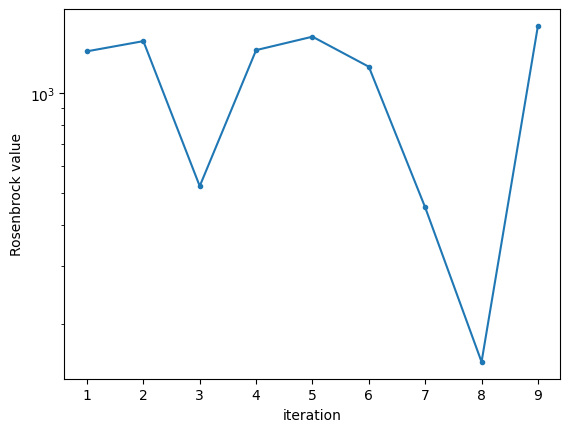

In [28]:
import matplotlib.pyplot as plt
X.data['f'].plot(marker='.')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')
best=dict(X.data.iloc[X.data["f"].argmax()]);

if normalize:
    for key in yaml_output['vocs']['variables'].keys():
        best[key] = unnormalize_var(key, best[key])

best
#var1 = hexapod ypos
#var2 = hexapod zpos
hexapod.set('ypos', best['var1'])
hexapod.set('zpos', best['var2'])